# Analyze Twitter Networks

So far we collected Tweet IDs, dehydrated them to get actual content, identified users, and colledted Botometer scores for those users. 

Let's put all these information together in this final step and see what we can learn from the network and the available metadata.

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import json
import gzip
import numpy as np
import pandas as pd
import datetime
from dateutil.parser import parse

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import networkx as nx

from config import DATA_PATH

In [27]:
def iterate_tweet_content():
    with gzip.open('../data/tweets_dehydrated.jsons.gz', 'rb') as fl:
        for line in fl:
            tweet = json.loads(line)
            yield tweet
            
for tweet in iterate_tweet_content():
    print(tweet)
    break

{'created_at': 'Sun May 10 20:28:06 +0000 2020', 'id': 1259580998586716162, 'id_str': '1259580998586716162', 'text': '#MilliHesaplarTakipte', 'truncated': False, 'entities': {'hashtags': [{'text': 'MilliHesaplarTakipte', 'indices': [0, 21]}], 'symbols': [], 'user_mentions': [], 'urls': []}, 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 913841350130520065, 'id_str': '913841350130520065', 'name': '🇹🇷🇹🇷Engin Değirmenci🇹🇷🇹🇷', 'screen_name': 'huduluengin75', 'location': '', 'description': 'ERZİNCAN lı heyecanlı.', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 157, 'friends_count': 257, 'listed_count': 0, 'created_at': 'Fri Sep 29 19:02:11 +0000 2017', 'favourites_count': 6401, 'utc_offset': None, 'time_zone': None, 'ge

In [33]:
# Build retweet - mention - reply network

userProfile = dict()
infoNet = nx.DiGraph() # Keep stats of min&max dates, count etc.
for c,tweet in enumerate(iterate_tweet_content()):
    connections = list()
    tdate = parse(tweet['created_at'])
    uid = tweet['user']['id_str']
    if uid not in userProfile:
        userProfile[uid] = tweet['user']
    
    if tweet['in_reply_to_user_id'] != None:
        connections.append((uid, tweet['in_reply_to_user_id'], 'reply'))
        
    if 'retweeted_status' in tweet:
        rid = tweet['retweeted_status']['user']['id_str']
        connections.append((rid, uid, 'retweet'))
        if rid not in userProfile:
            userProfile[rid] = tweet['retweeted_status']['user']
    
    for m in tweet['entities']['user_mentions']:
        connections.append((uid, m['id_str'], 'mention'))
    
    for conn in connections:
        if not infoNet.has_edge(conn[0], conn[1]):
            infoNet.add_edge(conn[0], conn[1], reply=0, retweet=0, mention=0,
                             datemin=tdate, datemax=tdate, count=0)
        
        infoNet[conn[0]][conn[1]][conn[2]] += 1
        infoNet[conn[0]][conn[1]]['datemin'] = min(infoNet[conn[0]][conn[1]]['datemin'], tdate)
        infoNet[conn[0]][conn[1]]['datemax'] = max(infoNet[conn[0]][conn[1]]['datemax'], tdate)
        infoNet[conn[0]][conn[1]]['count'] += 1
        
        
    if (c % 1000000) == 0:
        print(nx.info(infoNet))
    
print(nx.info(infoNet))

Name: 
Type: DiGraph
Number of nodes: 0
Number of edges: 0

Name: 
Type: DiGraph
Number of nodes: 69069
Number of edges: 338911
Average in degree:   4.9068
Average out degree:   4.9068


In [34]:
for n in infoNet.nodes():
    if n not in userProfile:
        continue
    infoNet.nodes[n]['nfriends'] = userProfile[n]['friends_count']
    infoNet.nodes[n]['nfollowers'] = userProfile[n]['followers_count']
    infoNet.nodes[n]['nstatuses'] = userProfile[n]['statuses_count']
    infoNet.nodes[n]['nfavorites'] = userProfile[n]['favourites_count']
    
    infoNet.nodes[n]['screen_name'] = userProfile[n]['screen_name']
    #infoNet.nodes[n]['user_name'] = userProfile[n]['name']
    infoNet.nodes[n]['creation_year'] = userProfile[n]['created_at'].split()[-1]
    

In [67]:
# Read Botometer Scores

#BOTOMETER_SCORE_FILE = '../data/botometer_scores.jsons.gz'
BOTOMETER_SCORE_FILE = '../data/botometer_scores.jsons'
BOTOMETER_ERROR_FILE = '../data/botometer_scores.errors'

## Collect already existing scores from previous runs
botometerScores = dict()
try:
    #with gzip.open(BOTOMETER_SCORE_FILE, 'r') as fl:
    with open(BOTOMETER_SCORE_FILE, 'r') as fl:
        for line in fl:
            try:
                temp = json.loads(line)
                botometerScores[temp['user']['id_str']] = temp
            except:
                pass
except Exception as e:
    print(e)
print('Scores for {} accounts already collected'.format(len(botometerScores)))


## Collect IDs of the accounts that are either deleted or suspended
removedAccounts = set()
try:
    with open(BOTOMETER_ERROR_FILE, 'r') as fl:
        for line in fl:
            removedAccounts.add(line.strip())
except Exception as e:
    print(e)
print('{} accounts unaccessible'.format(len(removedAccounts)))


### Add Botometer Scores to network
hasBotometerScore = set()
for n in infoNet.nodes():
    if n in botometerScores:
        infoNet.nodes[n]['botometer_eng'] = np.ceil(botometerScores[n]['scores']['english']*5)
        infoNet.nodes[n]['botometer_uni'] = np.ceil(botometerScores[n]['scores']['universal']*5)
        hasBotometerScore.add(n)
        
    if n in removedAccounts:
        infoNet.nodes[n]['botometer_eng'] = -1
        infoNet.nodes[n]['botometer_uni'] = -1
        hasBotometerScore.add(n)


### NOTE: SINCE THIS ANALYSIS ONLY COLLECTED BOTOMETER SCORES FOR THE INITIAL LIST
###       WE MIGHT WANT TO COLLECT DATA FOR THE OTHER NODES THAT ARE NOT PART OF
###.      THE ORIGINAL COLLECTION OF USERS.
#'''
with open('../data/demo_addition_users_for_botanalysis.txt', 'w') as fl:
    degSeq = {n:d for n,d in infoNet.degree()}
    for n in sorted(degSeq, key=degSeq.get, reverse=True):
        fl.write('{}\n'.format(n))
#'''


Scores for 66383 accounts already collected
6677 accounts unaccessible


In [36]:
for u,v,d in infoNet.edges.data():
    infoNet[u][v]['datediff'] = (infoNet[u][v]['datemax'] - infoNet[u][v]['datemin']).days
    infoNet[u][v]['datemin'] = infoNet[u][v]['datemin'].strftime("%Y-%m-%d %H:%M:%S")
    infoNet[u][v]['datemax'] = infoNet[u][v]['datemax'].strftime("%Y-%m-%d %H:%M:%S")

degreeSeq = {n:d for n,d in infoNet.degree()}
for n in sorted(degreeSeq, key=degreeSeq.get, reverse=True)[:100]:
    if n in userProfile:
        infoNet.nodes[n]['viz_label'] = userProfile[n]['screen_name']
    
#nx.write_gexf(infoNet, '../data/demo_infonet-alldata.gexf')
#nx.write_gexf(infoNet, '{}/demo_infonet-alldata.gexf'.format(DATA_PATH))

In [37]:

toRemove = list()
for n,d in infoNet.degree():
    if d < 5:
        toRemove.append(n)

for n in toRemove:
    infoNet.remove_node(n)
    
print(nx.info(infoNet))
nx.write_gexf(infoNet, '../data/demo_infonet-filtered.gexf')

'''
toRemove = set(infoNet.nodes()) - (removedAccounts | set(botometerScores.keys()))
print(len(toRemove))

for n in toRemove:
    infoNet.remove_node(n)

print(nx.info(infoNet))
nx.write_gexf(infoNet, '../data/demo_infonet-subnet.gexf')
'''

Name: 
Type: DiGraph
Number of nodes: 21889
Number of edges: 245963
Average in degree:  11.2368
Average out degree:  11.2368


"\ntoRemove = set(infoNet.nodes()) - (removedAccounts | set(botometerScores.keys()))\nprint(len(toRemove))\n\nfor n in toRemove:\n    infoNet.remove_node(n)\n\nprint(nx.info(infoNet))\nnx.write_gexf(infoNet, '../data/demo_infonet-subnet.gexf')\n"

# Analyze network data

In [65]:
# Build user-hashtag bipartite network
# Weights for direct share vs. dissemination

screenname2id = dict()
uhNet = nx.Graph()
for c,tweet in enumerate(iterate_tweet_content()):
    
    # Be careful when building network with screenname since it can change, 
    # but it's easier to build network for this use case.
    uid = '@{}'.format(tweet['user']['screen_name'].lower())
    screenname2id[uid] = tweet['user']['id_str']
        
    for h in tweet['entities']['hashtags']:
        htag = '#{}'.format(h['text'].lower())
        
        if not uhNet.has_edge(uid, htag):
            uhNet.add_edge(uid, htag, weight=1)
        else:
            uhNet[uid][htag]['weight'] += 1
            
for n in uhNet.nodes():
    uhNet.nodes[n]['type'] = 'user' if n.startswith('@') else 'hashtag'
    
print(nx.info(uhNet))
    

toRemove = set()
for ntype in ['user', 'hashtag']:
    degreeSeq = {n:d for n,d in uhNet.degree() if uhNet.nodes[n]['type'] == ntype}
    for n in sorted(degreeSeq, key=degreeSeq.get, reverse=True)[:50]:
        uhNet.nodes[n]['viz_label'] = n
    
    toRemove |= set([n for n in degreeSeq if degreeSeq[n] < 3])

'''
for n in toRemove:
    uhNet.remove_node(n)
    
print(nx.info(uhNet))

nx.write_gexf(uhNet, '../data/demo_uhnet-filtered.gexf')
'''
    

Name: 
Type: Graph
Number of nodes: 66712
Number of edges: 117573
Average degree:   3.5248


"\nfor n in toRemove:\n    uhNet.remove_node(n)\n    \nprint(nx.info(uhNet))\n\nnx.write_gexf(uhNet, '../data/demo_uhnet-filtered.gexf')\n"

@huduluengin75 #millihesaplartakipte {'weight': 1}


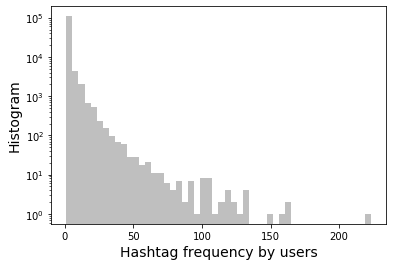

In [62]:
# Edge weight distribution

for m,n,d in uhNet.edges(data=True):
    print(m,n,d)
    break

fig = plt.figure(figsize=(6,4))
plt.hist([d['weight'] for m,n,d in uhNet.edges(data=True)], 
         bins=50, color='0.5', alpha=0.5)
plt.xlabel('Hashtag frequency by users', fontsize=14)
plt.ylabel('Histogram', fontsize=14)
plt.yscale('log')


3845
['#millihesaplarburada', '#millihesaplaryanyana', '#millihesaplarburda', '#milliyetçihesaplaryanyana', '#milliyetcihesaplaryanyana', '#millihesaplartakipte', '#teröregeçityok', '#millibirlikhareketi', '#millihesaplarbüyüyor', '#tcsavunma', '#millihesaplaryanana', '#millihesaplartakiplesiyor', '#türkiyemuzmçvşasahipçık', '#sehitlertepesiuzmcvslarin', '#cumhurbaşkanıerdoğan', '#milliveyerlihesaplartakiplesiyor', '#milliteknolojihamlesi', '#millihesaplartakipleşiyor', '#millihesaplaryanyan', '#millihesaplarbayramlasıyor', '#devletilemilletyanyana', '#millitakipsözü', '#erdoğandanbirsözyaz', '#millihesaplarbayramlaşıyor', '#sezaikarakoçtürkiyedir', '#bizbizeyeteriztürkiyem', '#teroeregecityok', '#2002ruhuyla2023e', '#akpartikayseri', '#ff', '#ekonomikdarbelerehayır', '#bizbizeyeteriz', '#ülkücütakipbaşlasın', '#receptayyiperdogan', '#türkiye', '#birliktebasaracagiz', '#hayırlıbayramlarreis', '#sahur', '#pazartesi', '#hayatevesigar', '#akıncıbelgeseli', '#millihesaplaryanya', '#akıncı2

/Users/onurvarol/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12484 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/onurvarol/anaconda/lib/python3.6/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 12484 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/onurvarol/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:2001: RuntimeWarning: Glyph 12484 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/onurvarol/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:2099: RuntimeWarning: Glyph 12484 missing from current font.
  flags=LOAD_NO_HINTING)
/Users/onurvarol/anaconda/lib/python3.6/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 12484 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/onurvarol/anaconda/li

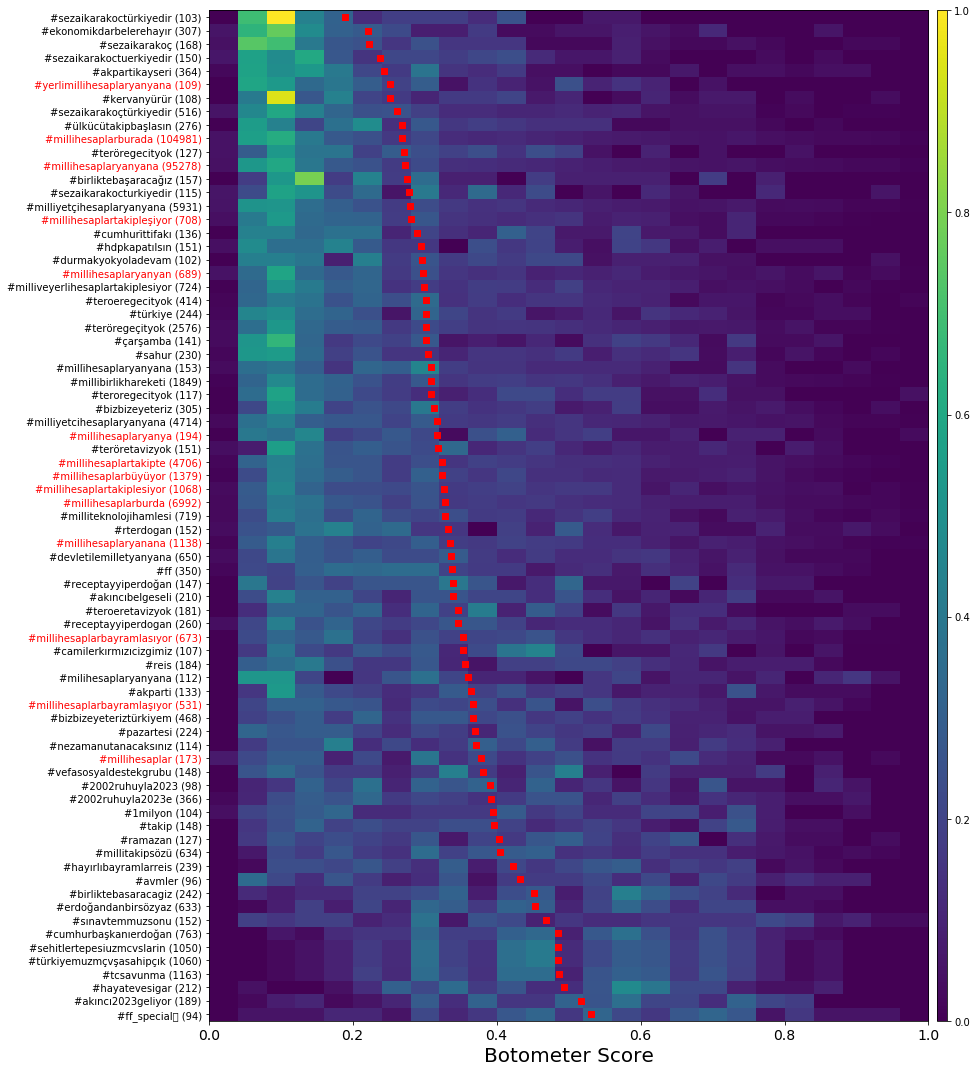

In [135]:
# Who shares what?

hashtagFreq = {n:0 for n in uhNet.nodes() if n[0] == '#'}
for m,n,d in uhNet.edges(data=True):
    if m[0] == '#':
        hashtagFreq[m] += d['weight']
    if n[0] == '#':
        hashtagFreq[n] += d['weight']
print(len(hashtagFreq))

topHashtags = sorted(hashtagFreq, key=hashtagFreq.get, reverse=True)[:75]
print(topHashtags)

htagBotDist = {h:list() for h in topHashtags}
for i,h in enumerate(topHashtags):
    for u in uhNet.neighbors(h):
        if screenname2id[u] in botometerScores:
            htagBotDist[h].append(botometerScores[screenname2id[u]]['scores']['universal'])

nBins = 25
dataM = np.zeros((len(topHashtags), nBins))
yvals = list()
for i,h in enumerate(sorted(htagBotDist, key=lambda k: np.mean(htagBotDist[k]), reverse=True)):
    vals, bins = np.histogram(htagBotDist[h], bins=np.linspace(0,1,nBins+1))
    dataM[i,:] = vals / np.sum(vals)
    yvals.append(h)
    

fig = plt.figure(figsize=(15,15))
plt.imshow(dataM, interpolation='nearest', aspect='auto', origin='lower', extent=[0,1,-0.5,len(yvals)-0.5])
plt.scatter([np.mean(htagBotDist[h]) for h in yvals], range(len(yvals)), color='r', marker='s')
_ = plt.yticks(range(len(yvals)), ['{} ({})'.format(y, hashtagFreq[y]) for y in yvals])
plt.ylim(-0.5,len(yvals)-0.5)

plt.xticks(fontsize=14)
plt.xlabel('Botometer Score', fontsize=20)
for ytick in plt.gca().get_yticklabels():
    if 'millihesap' in str(ytick):
        ytick.set_color("red")

plt.colorbar(aspect=100, pad=0.01)
plt.tight_layout()

plt.savefig('../figures/demo-hashtag-botscore-dist.pdf', bbox_inches = "tight", transparent=True, dpi=300)
